In [1]:
import argparse
import os
import operator
import pickle
import time

import csv
import datetime
import numpy as np
from collections import Counter

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--save-dir', default='diginetica_temp', help='save directory name')
opt = parser.parse_args([])
print(opt)

Namespace(save_dir='diginetica_temp')


In [3]:
if not os.path.exists(f'../{opt.save_dir}'):
    os.makedirs(f'../{opt.save_dir}')


In [4]:
print("-- Starting @ %ss" % datetime.datetime.now())

with open('../raw/train-item-views.csv', "r") as f:
    reader = csv.DictReader(f, delimiter=';')
    sess_clicks = {}
    sess_date = {}
    ctr = 0
    curid = -1
    curdate = None
    for data in reader:
        sessid = data['sessionId']
        if curdate and curid != sessid:
            # date = curdate
            date = ''
            date = time.mktime(time.strptime(curdate, '%Y-%m-%d')) #timestamp
            sess_date[curid] = date
        curid = sessid
        # item = data['itemId']
        item = data['itemId'], int(data['timeframe'])
        curdate = ''
        curdate = data['eventdate']

        if sessid in sess_clicks:
            sess_clicks[sessid] += [item]
        else:
            sess_clicks[sessid] = [item]
        ctr += 1
    date = time.mktime(time.strptime(curdate, '%Y-%m-%d'))
    # add
    for i in list(sess_clicks):
        sorted_clicks = sorted(sess_clicks[i], key=operator.itemgetter(1))
        sess_clicks[i] = [c[0] for c in sorted_clicks]
    sess_date[curid] = date
print("-- Reading data @ %ss" % datetime.datetime.now())

-- Starting @ 2022-10-10 16:23:51.769560s
-- Reading data @ 2022-10-10 16:24:12.111694s


In [5]:
# Filter out length shorter than 2
for s in list(sess_clicks):
    if len(sess_clicks[s]) < 2 :
        del sess_clicks[s]
        del sess_date[s]

# Counter number of times each appears
iid_counts = {}
for s in sess_clicks:
    seq = sess_clicks[s]
    for iid in seq:
        if iid in iid_counts:
            iid_counts[iid] += 1
        else:
            iid_counts[iid] = 1

sorted_counts = sorted(iid_counts.items(), key=operator.itemgetter(1))

length = len(sess_clicks)
for s in list(sess_clicks):
    curseq = sess_clicks[s]
    filseq = list(filter(lambda i: iid_counts[i] >= 5, curseq))

    if len(filseq) < 2 :
        del sess_clicks[s]
        del sess_date[s]
    else:
        sess_clicks[s] = filseq

dates = list(sess_date.items())
maxdate = dates[0][1]

for _, date in dates:
    if maxdate < date:
        maxdate = date

# 7 days for test
splitdate = 0
splitdate = maxdate - 86400 * 7

print('Splitting date', splitdate)      # Yoochoose: ('Split date', 1411930799.0)
tra_sess = filter(lambda x: x[1] < splitdate, dates)
tes_sess = filter(lambda x: x[1] > splitdate, dates)

Splitting date 1464102000.0


In [7]:
item_dict, item_cnt = {}, {}

# train
train_ids, train_seqs, train_dates = [], [], []
item_ctr = 1

for s, date in tra_sess:
    seq = sess_clicks[s]
    outseq = []
    for i in seq:
        if i in item_dict:
            outseq += [item_dict[i]]
            item_cnt[item_dict[i]] += 1
        else:
            outseq += [item_ctr]
            item_dict[i] = item_ctr
            item_cnt[item_dict[i]] = 1
            item_ctr += 1
    if len(outseq) < 2: 
        continue
    train_ids += [s]
    train_dates += [date]
    train_seqs += [outseq]

# test
test_ids = []
test_seqs = []
test_dates = []
for s, date in tes_sess:
    seq = sess_clicks[s]
    outseq = []
    for i in seq:
        if i in item_dict:
            outseq += [item_dict[i]]
    if len(outseq) < 2:
        continue
    test_ids += [s]
    test_dates += [date]
    test_seqs += [outseq]

In [8]:
print(min(item_dict.values()), max(item_dict.values()))

1 43097


In [9]:
def process_seqs(iseqs, idates, train=True):
    out_seqs, labs = [], []
    
    if train:
        out_dates, ids = [], []

        for id, seq, date in zip(range(len(iseqs)), iseqs, idates):
            for i in range(1, len(seq)):
                tar = seq[-i]
                labs += [tar]
                out_seqs += [seq[:-i]]
                out_dates += [date]
                ids += [id]
        return out_seqs, out_dates, labs, ids
    else:
        for seq in iseqs:
            labs += [seq[-1]]
            out_seqs += [seq[:-1]]
        return out_seqs, labs

In [10]:
tra_seqs, tra_dates, tra_labs, tra_ids = process_seqs(train_seqs, train_dates)
tes_seqs, tes_labs = process_seqs(test_seqs, None, False)

In [11]:
print(max(tes_seqs), max(tes_labs), max(tra_seqs), max(tes_labs))

[43090, 43090, 43090, 43090] 43095 [43095, 7101, 723, 111, 12548, 2881, 2881] 43095


In [12]:
print(min(item_cnt.keys()), max(item_cnt.keys()))

1 43097


In [13]:
print(f"# train sessions {len(tra_seqs)}, ex. {tra_seqs[:3], tra_labs[:3]}")
print(f"# test sessions {len(tes_seqs)}, ex. {tes_seqs[:3], tes_labs[:3]}")
print(f"# train clicks {sum(item_cnt.values())}")
print(f"# items {len(item_cnt.keys())}")
print(f"avg. length : {sum(map(len, tra_seqs)) / len(tra_seqs)}")

# train sessions 719462, ex. ([[1, 2, 3, 4, 5, 6, 4, 2, 7], [1, 2, 3, 4, 5, 6, 4, 2], [1, 2, 3, 4, 5, 6, 4]], [8, 7, 2])
# test sessions 15963, ex. ([[21152, 10178, 14344, 40488, 34042], [12258], [9626, 390]], [40488, 12674, 9626])
# train clicks 906131
# items 43097
avg. length : 4.132764482349311


In [14]:
tra = (tra_seqs, tra_labs)
tes = (tes_seqs, tes_labs)

In [15]:
pickle.dump(tra, open(f'../{opt.save_dir}/train.txt', 'wb'))
pickle.dump(tes, open(f'../{opt.save_dir}/test.txt', 'wb'))
pickle.dump(len(item_cnt.keys()) + 1, open(f'../{opt.save_dir}/n_node.txt', 'wb'))

In [16]:
# Popularity dict
total_ctr = sum(item_cnt.values())
pop_dict = {key : (value / total_ctr) for key, value in item_cnt.items()}

pickle.dump(pop_dict, open(f"../{opt.save_dir}/pop_dict.pickle", "wb"))

In [21]:
max(pop_dict.values()) * 100

0.1005373395237554

In [20]:
# head tail dict 
sorted_item_cnt = sorted(item_cnt.items(), reverse=True, key=lambda item: item[1])
sorted_keys = np.array(sorted_item_cnt)[:, 0].astype(int)
sorted_values = np.array(sorted_item_cnt)[:, 1]

split_point = int(len(sorted_keys) * 0.2)
point_cnt_value = sorted_values[split_point]
split_idx = [i for i, cnt in enumerate(sorted_values) if cnt == (point_cnt_value-1)][0]

ht_dict = dict()
ht_dict['head'] = sorted_keys[:split_idx]
ht_dict['tail'] = sorted_keys[split_idx:]

print(f'# head items : {len(ht_dict["head"])}, # tail items : {len(ht_dict["tail"])}')
pickle.dump(ht_dict, open(f'../{opt.save_dir}/ht_dict.pickle', 'wb'))

# head items : 8678, # tail items : 34419


In [24]:
sorted_values

array([911, 880, 806, ...,   1,   1,   1])

In [25]:
sum_sorted_values = sum(sorted_values)

In [26]:
print(sum_sorted_values, sum_sorted_values*0.8)

906131 724904.8


In [37]:
summ = 0
for i, value, in enumerate(sorted_values):
    summ += value
    if value < 14:
        print(i, value)
        break

16913 13


In [38]:
sum(sorted_values[:16913])

715118

<BarContainer object of 26184 artists>

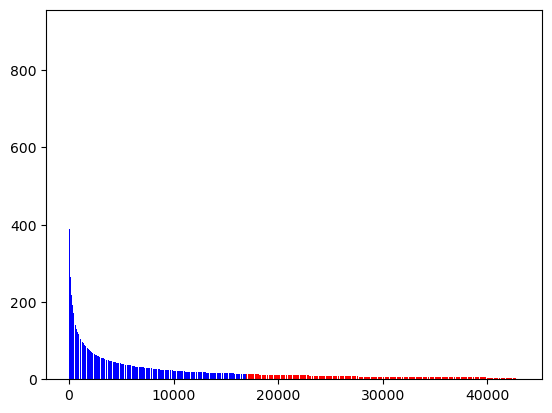

In [40]:
import matplotlib.pyplot as plt
plt.bar(np.arange(16913), sorted_values[:16913], color='blue')
plt.bar(np.arange(16913, len(sorted_values)), sorted_values[16913:], color='red')

<BarContainer object of 34419 artists>

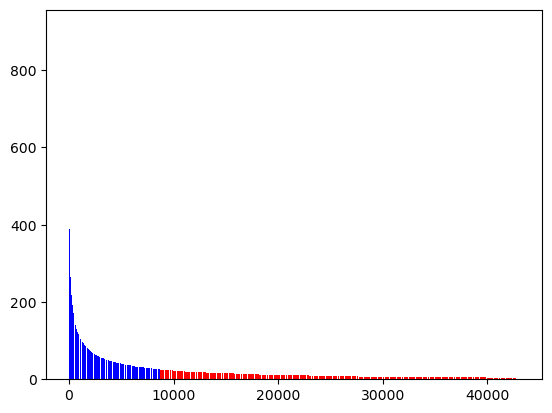

In [41]:
import matplotlib.pyplot as plt
plt.bar(np.arange(8678), sorted_values[:8678], color='blue')
plt.bar(np.arange(8678, len(sorted_values)), sorted_values[8678:], color='red')